In [1]:
#!pip install catboost
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import catboost as cb
import optuna
import pickle

from utils import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/Users/gaby/miniforge3/envs/KCML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_estres = pd.read_csv('../XGBoost_Stress_Regressor/Sin_columnas_resultados_test_ni_estados_animo_XGB_2/SWELLdata.csv', decimal=",", delimiter=";")
df_estres.head()

,PP,Blok,Condition,timestamp,Valence_rc,Arousal_rc,Dominance,Stress,MentalEffort,MentalDemand,...,WristLeft_HandLeftPlaneYZAxisZstdv,ShoulderRight_ElbowRightPlaneZXAxisXstdv,ShoulderRight_ElbowRightPlaneXYAxisYstdv,ShoulderRight_ElbowRightPlaneYZAxisZstdv,ElbowRight_WristRightPlaneZXAxisXstdv,ElbowRight_WristRightPlaneXYAxisYstdv,ElbowRight_WristRightPlaneYZAxisZstdv,WristRight_HandRightPlaneZXAxisXstdv,WristRight_HandRightPlaneXYAxisYstdv,WristRight_HandRightKinectZAxisstdv
0,PP1,1,R,20120918T131600000,NaN,NaN,NaN,NaN,NaN,NaN,...,166.872086,22.946337,5.605230,13.237048,30.932939,102.460262,8.444481,54.436879,75.886750,155.734343
1,PP1,1,R,20120918T131700000,NaN,NaN,NaN,NaN,NaN,NaN,...,58.237714,7.194860,2.468881,3.886001,2.000359,3.431337,1.160298,4.579341,2.868843,171.486911
2,PP1,1,R,20120918T131800000,NaN,NaN,NaN,NaN,NaN,NaN,...,64.548824,14.726365,2.953021,9.185623,13.379140,48.162012,30.508877,23.013755,30.629061,149.748809
3,PP1,1,R,20120918T131900000,NaN,NaN,NaN,NaN,NaN,NaN,...,38.209895,2.542686,1.564318,2.453674,4.796273,8.223865,1.114906,3.854074,4.048611,173.149430
4,PP1,1,R,20120918T132000000,NaN,NaN,NaN,NaN,NaN,NaN,...,80.171422,9.905241,20.342488,5.552234,7.198096,22.942488,46.386278,17.514534,29.702675,165.368301


In [4]:
formateo_fechas(df_estres)

,PP,Blok,Condition,timestamp,Valence_rc,Arousal_rc,Dominance,Stress,MentalEffort,MentalDemand,...,WristLeft_HandLeftPlaneYZAxisZstdv,ShoulderRight_ElbowRightPlaneZXAxisXstdv,ShoulderRight_ElbowRightPlaneXYAxisYstdv,ShoulderRight_ElbowRightPlaneYZAxisZstdv,ElbowRight_WristRightPlaneZXAxisXstdv,ElbowRight_WristRightPlaneXYAxisYstdv,ElbowRight_WristRightPlaneYZAxisZstdv,WristRight_HandRightPlaneZXAxisXstdv,WristRight_HandRightPlaneXYAxisYstdv,WristRight_HandRightKinectZAxisstdv
0,PP1,1,R,2012-09-18 13:16:00,NaN,NaN,NaN,NaN,NaN,NaN,...,166.872086,22.946337,5.605230,13.237048,30.932939,102.460262,8.444481,54.436879,75.886750,155.734343
1,PP1,1,R,2012-09-18 13:17:00,NaN,NaN,NaN,NaN,NaN,NaN,...,58.237714,7.194860,2.468881,3.886001,2.000359,3.431337,1.160298,4.579341,2.868843,171.486911
2,PP1,1,R,2012-09-18 13:18:00,NaN,NaN,NaN,NaN,NaN,NaN,...,64.548824,14.726365,2.953021,9.185623,13.379140,48.162012,30.508877,23.013755,30.629061,149.748809
3,PP1,1,R,2012-09-18 13:19:00,NaN,NaN,NaN,NaN,NaN,NaN,...,38.209895,2.542686,1.564318,2.453674,4.796273,8.223865,1.114906,3.854074,4.048611,173.149430
4,PP1,1,R,2012-09-18 13:20:00,NaN,NaN,NaN,NaN,NaN,NaN,...,80.171422,9.905241,20.342488,5.552234,7.198096,22.942488,46.386278,17.514534,29.702675,165.368301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,PP25,3,T,2012-11-07 16:15:00,9.0,8.0,9.0,0.3,2.7,3.6,...,103.650684,36.355940,5.323538,17.908446,56.076888,124.607529,15.482486,87.838259,158.284130,38.905423
3135,PP25,3,T,2012-11-07 16:16:00,9.0,8.0,9.0,0.3,2.7,3.6,...,26.334438,14.714479,1.848907,3.908359,34.878709,159.984897,5.233569,63.512098,164.607803,27.895148
3136,PP25,3,T,2012-11-07 16:17:00,9.0,8.0,9.0,0.3,2.7,3.6,...,15.970939,22.742133,3.048023,6.468803,53.988308,169.548392,10.757358,60.488127,142.557094,21.761699
3137,PP25,3,T,2012-11-07 16:18:00,9.0,8.0,9.0,0.3,2.7,3.6,...,38.797002,28.595668,27.981837,8.424373,43.183524,55.599939,14.620391,72.590531,163.087296,28.944050


In [5]:
clasificar_momento_dia(df_estres)

,PP,Blok,Condition,timestamp,Valence_rc,Arousal_rc,Dominance,Stress,MentalEffort,MentalDemand,...,ShoulderRight_ElbowRightPlaneZXAxisXstdv,ShoulderRight_ElbowRightPlaneXYAxisYstdv,ShoulderRight_ElbowRightPlaneYZAxisZstdv,ElbowRight_WristRightPlaneZXAxisXstdv,ElbowRight_WristRightPlaneXYAxisYstdv,ElbowRight_WristRightPlaneYZAxisZstdv,WristRight_HandRightPlaneZXAxisXstdv,WristRight_HandRightPlaneXYAxisYstdv,WristRight_HandRightKinectZAxisstdv,momento_dia
0,PP1,1,R,2012-09-18 13:16:00,NaN,NaN,NaN,NaN,NaN,NaN,...,22.946337,5.605230,13.237048,30.932939,102.460262,8.444481,54.436879,75.886750,155.734343,tarde
1,PP1,1,R,2012-09-18 13:17:00,NaN,NaN,NaN,NaN,NaN,NaN,...,7.194860,2.468881,3.886001,2.000359,3.431337,1.160298,4.579341,2.868843,171.486911,tarde
2,PP1,1,R,2012-09-18 13:18:00,NaN,NaN,NaN,NaN,NaN,NaN,...,14.726365,2.953021,9.185623,13.379140,48.162012,30.508877,23.013755,30.629061,149.748809,tarde
3,PP1,1,R,2012-09-18 13:19:00,NaN,NaN,NaN,NaN,NaN,NaN,...,2.542686,1.564318,2.453674,4.796273,8.223865,1.114906,3.854074,4.048611,173.149430,tarde
4,PP1,1,R,2012-09-18 13:20:00,NaN,NaN,NaN,NaN,NaN,NaN,...,9.905241,20.342488,5.552234,7.198096,22.942488,46.386278,17.514534,29.702675,165.368301,tarde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,PP25,3,T,2012-11-07 16:15:00,9.0,8.0,9.0,0.3,2.7,3.6,...,36.355940,5.323538,17.908446,56.076888,124.607529,15.482486,87.838259,158.284130,38.905423,tarde
3135,PP25,3,T,2012-11-07 16:16:00,9.0,8.0,9.0,0.3,2.7,3.6,...,14.714479,1.848907,3.908359,34.878709,159.984897,5.233569,63.512098,164.607803,27.895148,tarde
3136,PP25,3,T,2012-11-07 16:17:00,9.0,8.0,9.0,0.3,2.7,3.6,...,22.742133,3.048023,6.468803,53.988308,169.548392,10.757358,60.488127,142.557094,21.761699,tarde
3137,PP25,3,T,2012-11-07 16:18:00,9.0,8.0,9.0,0.3,2.7,3.6,...,28.595668,27.981837,8.424373,43.183524,55.599939,14.620391,72.590531,163.087296,28.944050,tarde


In [6]:
#Eliminamos columnas que no son compatibles con nuestro problema ya que no tendremos esas features en nuestro datos de entrada de nuestra APP
columnas_a_eliminar = ['timestamp','HR','RMSSD', 'RMSSD','SCL','Valence_rc','Arousal_rc','Dominance','MentalEffort','MentalDemand','PhysicalDemand','TemporalDemand','Effort','Performance_rc','Frustration','NasaTLX','Squality','Sneutral','Shappy','Ssad','Sangry','Ssurprised','Sscared','Sdisgusted','Svalence']
df_estres = eliminar_columnas(df_estres, columnas_a_eliminar)

Se eliminaron las columnas: ['timestamp', 'HR', 'RMSSD', 'RMSSD', 'SCL', 'Valence_rc', 'Arousal_rc', 'Dominance', 'MentalEffort', 'MentalDemand', 'PhysicalDemand', 'TemporalDemand', 'Effort', 'Performance_rc', 'Frustration', 'NasaTLX', 'Squality', 'Sneutral', 'Shappy', 'Ssad', 'Sangry', 'Ssurprised', 'Sscared', 'Sdisgusted', 'Svalence']


In [7]:
#Filtramos para condición R no esté
df_estres = df_estres[df_estres['Condition'] != 'R']

In [8]:
#Mover columna momento_día a la cuarta posición
cols = list(df_estres.columns)
momento_dia_index = cols.index('momento_dia')
cols.pop(momento_dia_index)
cols.insert(3, 'momento_dia')
df_estres = df_estres[cols]

In [9]:
#Filtramos para condición momento_día_noche no este (solo hay 2)
df_estres = df_estres[df_estres['momento_dia'] != 'noche']

In [10]:
#Dividir los datos mezclandolos
X = df_estres.drop('Stress', axis=1)
y = df_estres['Stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #(,shuffle=True)

In [11]:
columnas_a_eliminar = ['PP']
X_train = eliminar_columnas(X_train, columnas_a_eliminar)

Se eliminaron las columnas: ['PP']


In [12]:
#Imputación con media, mediana o moda de nulo en X_train
stats_X_train = X_train.describe().T[['mean', '50%']].assign(mode=X_train.mode().iloc[0])

imputed_values = {}

for col in X_train.columns:
    if col in stats_X_train.index:  # Asegurar que la columna tiene estadísticas disponibles
        moda = stats_X_train.loc[col, 'mode']
        mediana = stats_X_train.loc[col, '50%']
        media = stats_X_train.loc[col, 'mean']

        if moda != 0:
            imputed_values[col] = X_train[col].fillna(moda)
        elif mediana != 0:
            imputed_values[col] = X_train[col].fillna(mediana)
        else:
            imputed_values[col] = X_train[col].fillna(media)

# Aplicar imputaciones en un solo paso sin modificar directamente el DataFrame original
X_train = X_train.assign(**imputed_values)

In [13]:
# Obtener la matriz de correlación absoluta solo para las columnas numéricas
X_train_num = X_train.select_dtypes(include=['number'])
corr_matrix = X_train_num.corr().abs()

# Eliminar la columna 'Stress' de la matriz de correlación (si está presente)
if 'Stress' in corr_matrix.columns:
    corr_matrix = corr_matrix.drop('Stress', axis=1).drop('Stress', axis=0)

# Seleccionar las columnas con correlación > 0.9 (excepto la diagonal)
high_corr_cols = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_cols.add(colname)

# Eliminar las columnas redundantes en X_train
X_train.drop(columns=high_corr_cols, inplace=True)

print(f"Eliminadas {len(high_corr_cols)} columnas altamente correlacionadas entre sí (sin considerar 'Stress').")
print(f"Columnas eliminadas: {list(high_corr_cols)}")

Eliminadas 20 columnas altamente correlacionadas entre sí (sin considerar 'Stress').
Columnas eliminadas: ['ShoulderCenter_ShoulderRightPlaneXYAxisYstdv', 'SnSpaces', 'Spine_ShoulderCenterPlaneYZAxisZstdv', 'Spine_ShoulderCenterPlaneXYAxisYavg', 'HipCenter_SpinePlaneXYAxisYavg', 'ShoulderRight_ElbowRightPlaneXYAxisYavg', 'ShoulderCenter_ShoulderRightPlaneXYAxisYavg', 'Spine_ShoulderCenterShoulderCenter_Headavg', 'SnChars', 'Spine_ShoulderCenterPlaneYZAxisZavg', 'ShoulderCenter_ShoulderLeftPlaneXYAxisYavg', 'ElbowLeft_WristLeftWristLeft_HandLeftavg', 'HipCenter_SpineSpine_ShoulderCenteravg', 'ShoulderCenter_ShoulderLeftShoulderLeft_ElbowLeftavg', 'HipCenter_SpinePlaneYZAxisZavg', 'SAu25_LipsPart', 'Spine_ShoulderCenterShoulderCenter_ShoulderLeftavg', 'ShoulderCenter_ShoulderLeftPlaneXYAxisYstdv', 'ShoulderCenter_ShoulderRightPlaneZXAxisXavg', 'ShoulderCenter_ShoulderRightPlaneYZAxisZavg']


In [14]:
#Eliminamos las mismas columnas que en X_test
columnas_a_eliminar = ['PP']+list(high_corr_cols)
X_test = eliminar_columnas(X_test, columnas_a_eliminar)
#X_test.drop(columns=high_corr_cols, inplace=True)


Se eliminaron las columnas: ['PP', 'ShoulderCenter_ShoulderRightPlaneXYAxisYstdv', 'SnSpaces', 'Spine_ShoulderCenterPlaneYZAxisZstdv', 'Spine_ShoulderCenterPlaneXYAxisYavg', 'HipCenter_SpinePlaneXYAxisYavg', 'ShoulderRight_ElbowRightPlaneXYAxisYavg', 'ShoulderCenter_ShoulderRightPlaneXYAxisYavg', 'Spine_ShoulderCenterShoulderCenter_Headavg', 'SnChars', 'Spine_ShoulderCenterPlaneYZAxisZavg', 'ShoulderCenter_ShoulderLeftPlaneXYAxisYavg', 'ElbowLeft_WristLeftWristLeft_HandLeftavg', 'HipCenter_SpineSpine_ShoulderCenteravg', 'ShoulderCenter_ShoulderLeftShoulderLeft_ElbowLeftavg', 'HipCenter_SpinePlaneYZAxisZavg', 'SAu25_LipsPart', 'Spine_ShoulderCenterShoulderCenter_ShoulderLeftavg', 'ShoulderCenter_ShoulderLeftPlaneXYAxisYstdv', 'ShoulderCenter_ShoulderRightPlaneZXAxisXavg', 'ShoulderCenter_ShoulderRightPlaneYZAxisZavg']


In [15]:
#Imputación con media, mediana o moda de nulo en X_test
stats_X_test = X_test.describe().T[['mean', '50%']].assign(mode=X_test.mode().iloc[0])

imputed_values = {}

for col in X_test.columns:
    if col in stats_X_test.index:  # Asegurar que la columna tiene estadísticas disponibles
        moda = stats_X_test.loc[col, 'mode']
        mediana = stats_X_test.loc[col, '50%']
        media = stats_X_test.loc[col, 'mean']

        if moda != 0:
            imputed_values[col] = X_test[col].fillna(moda)
        elif mediana != 0:
            imputed_values[col] = X_test[col].fillna(mediana)
        else:
            imputed_values[col] = X_test[col].fillna(media)

# Aplicar imputaciones en un solo paso sin modificar directamente el DataFrame original
X_test = X_test.assign(**imputed_values)

In [16]:
# Identificar columnas categóricas
categorical_features = ['Blok', 'Condition', 'momento_dia']

In [17]:
#modelo 2

import optuna
import catboost as cb
from catboost import CatBoostRegressor, Pool
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Crear Pool de datos para optimización
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Definir la función objetivo para Optuna
def objective_cb(trial):
    # Espacio de búsqueda de hiperparámetros
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bernoulli", "MVS", "Bayesian"])

    params = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "depth": trial.suggest_int("depth", 3, 4),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.02, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 20, 200, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
        "border_count": trial.suggest_int("border_count", 32, 128),
        "grow_policy": "SymmetricTree",
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "bootstrap_type": bootstrap_type,
        "loss_function": trial.suggest_categorical("loss_function", ["MAE", "RMSE"]),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 20, 60),
        "random_seed": 42,
        
    }

    if bootstrap_type in ["Bernoulli", "MVS"]:
        params["subsample"] = trial.suggest_float("subsample", 0.4, 0.8)
    
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.1, 1.0)

    # Cross-Validation con 5 Folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Crear Pool para cada fold
        train_fold = Pool(X_tr, y_tr, cat_features=categorical_features)
        val_fold = Pool(X_val, y_val, cat_features=categorical_features)

        # Entrenar el modelo
        model = CatBoostRegressor(**params, verbose=0)
        model.fit(train_fold, eval_set=val_fold, early_stopping_rounds=50, verbose=False)

        # Evaluar y almacenar el resultado
        preds = model.predict(val_fold)
        mae = mean_absolute_error(y_val, preds)
        cv_scores.append(mae)

    # Retornar el promedio del MAE de CV
    return np.mean(cv_scores)

# Crear el estudio y optimizar
study_2 = optuna.create_study(direction="minimize")
study_2.optimize(objective_cb, n_trials=250)

# Mejor conjunto de hiperparámetros
print(" Best parameters:", study_2.best_params)
print(" Best MAE (CV):", study_2.best_value)

# Entrenar el mejor modelo en todo el conjunto de entrenamiento
best_model_2 = CatBoostRegressor(**study_2.best_params)
best_model_2.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)

# Evaluar el mejor modelo
train_preds = best_model_2.predict(train_pool)
test_preds = best_model_2.predict(test_pool)


# Evaluar el modelo
mse_train = mean_squared_error(y_train, train_preds)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

# Imprimir las métricas
print(f" Métricas del Modelo CatBoost con Optuna, train:")
print(f" Error Cuadrático Medio (MSE): {mse_train:.4f}")
print(f" Raíz del Error Cuadrático Medio (RMSE): {rmse_train:.4f}")
print(f" Error Absoluto Medio (MAE): {mae_train:.4f}")
print(f" R-cuadrado (R²): {r2_train:.4f}")

print(f"\n Métricas del Mejor Modelo con Optuna,test:")
print(f" Error Cuadrático Medio (MSE): {mse_test:.4f}")
print(f" Raíz del Error Cuadrático Medio (RMSE): {rmse_test:.4f}")
print(f" Error Absoluto Medio (MAE): {mae_test:.4f}")
print(f" R-cuadrado (R²): {r2_test:.4f}")


[I 2025-04-01 10:40:36,531] A new study created in memory with name: no-name-fe6e5bc2-06e1-402c-b0c9-c9f3cf3f0d01
[I 2025-04-01 10:40:43,100] Trial 0 finished with value: 1.2204620037551712 and parameters: {'bootstrap_type': 'MVS', 'iterations': 918, 'depth': 4, 'learning_rate': 0.010833410423931461, 'l2_leaf_reg': 158.26940214530154, 'random_strength': 1.1388138319030672, 'border_count': 78, 'min_data_in_leaf': 42, 'loss_function': 'RMSE', 'od_type': 'IncToDec', 'od_wait': 43, 'subsample': 0.6115579686630719}. Best is trial 0 with value: 1.2204620037551712.
[I 2025-04-01 10:40:50,948] Trial 1 finished with value: 0.8365428623086795 and parameters: {'bootstrap_type': 'MVS', 'iterations': 1451, 'depth': 3, 'learning_rate': 0.01945666393183604, 'l2_leaf_reg': 46.55294861213919, 'random_strength': 1.325504264499932, 'border_count': 121, 'min_data_in_leaf': 45, 'loss_function': 'RMSE', 'od_type': 'Iter', 'od_wait': 49, 'subsample': 0.6814838877200662}. Best is trial 1 with value: 0.8365428

 Best parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 1289, 'depth': 4, 'learning_rate': 0.017993036254249285, 'l2_leaf_reg': 23.335645649737415, 'random_strength': 0.7171275000339349, 'border_count': 72, 'min_data_in_leaf': 10, 'loss_function': 'RMSE', 'od_type': 'Iter', 'od_wait': 53, 'subsample': 0.792685982301779}
 Best MAE (CV): 0.6881411014096901
 Métricas del Modelo CatBoost con Optuna, train:
 Error Cuadrático Medio (MSE): 0.4172
 Raíz del Error Cuadrático Medio (RMSE): 0.6459
 Error Absoluto Medio (MAE): 0.4936
 R-cuadrado (R²): 0.9094

 Métricas del Mejor Modelo con Optuna,test:
 Error Cuadrático Medio (MSE): 0.8159
 Raíz del Error Cuadrático Medio (RMSE): 0.9033
 Error Absoluto Medio (MAE): 0.6762
 R-cuadrado (R²): 0.8258


In [25]:
#Se guarda el modelo 2 en .cbm

best_model_2.save_model("model_catboost_2.cbm")

In [26]:
# Guardar los parámetros y métricas en un archivo JSON
results_2 = {
    "best_params": study_2.best_params,
    "mse_train": mse_train,
    "rmse_train": rmse_train,
    "r2_train": r2_train,
    "mae_train": mae_train,
    "mse_test": mse_test,
    "rmse_test": rmse_test,
    "r2_test": r2_test,
    "mae_test": mae_test
}
with open("results_catboost_2.json", "w") as f:
    json.dump(results_2, f, indent=4)

In [20]:
#modelo 1

# import optuna
# import catboost as cb
# from catboost import CatBoostRegressor
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error


# # Definir la función objetivo para Optuna
# def objective_cb(trial):
#     # Espacio de búsqueda de hiperparámetros
    
#     bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bernoulli", "MVS", "Bayesian"])

#     params = {
#         "iterations": trial.suggest_int("iterations", 500, 1500),
#         "depth": trial.suggest_int("depth", 3, 4),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.02, log=True),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 20, 200, log=True),
#         "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
#         "border_count": trial.suggest_int("border_count", 32, 128),
#         "grow_policy": "SymmetricTree",
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
#         "bootstrap_type": bootstrap_type,
#         "loss_function": trial.suggest_categorical("loss_function", ["MAE", "RMSE"]),
#         "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         "od_wait": trial.suggest_int("od_wait", 20, 60),
#         "random_seed": 42,
        
#     }
    

#     if bootstrap_type in ["Bernoulli", "MVS"]:
#         params["subsample"] = trial.suggest_float("subsample", 0.4, 0.8)
    
#     if bootstrap_type == "Bayesian":
#         params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.1, 1.0)

#     # Entrenar el modelo
#     model = CatBoostRegressor(**params,cat_features=categorical_features, verbose=0)
#     model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)
    
#     # Predicciones y evaluación
#     preds = model.predict(X_test)
#     mae = mean_absolute_error(y_test, preds)
    
#     return mae  # El objetivo es minimizar el MAE

# # Crear el estudio y optimizar
# study = optuna.create_study(direction="minimize")
# study.optimize(objective_cb, n_trials=250)

# # Mejor conjunto de hiperparámetros
# print("Best parameters:", study.best_params)
# print("Best MAE:", study.best_value)

#entreno modelo 1 con los hiperparam óptimos

# Reentrena el mejor modelo
# best_params = study.best_params
# best_model = CatBoostRegressor(**best_params,cat_features=categorical_features)
# best_model.fit(X_train, y_train)

# # Predicciones y Métricas Finales
# y_pred = best_model.predict(X_test)
# mse_test = mean_squared_error(y_test, y_pred)
# rmse_test = np.sqrt(mse_test)
# mae_test = mean_absolute_error(y_test, y_pred)
# r2_test = r2_score(y_test, y_pred)

# # Predecir en el conjunto de entrenamoiento
# y_pred_train = best_model.predict(X_train)

# # Evaluar el modelo
# mse_train = mean_squared_error(y_train, y_pred_train)
# rmse_train = np.sqrt(mse_train)
# mae_train = mean_absolute_error(y_train, y_pred_train)
# r2_train = r2_score(y_train, y_pred_train)

# # Imprimir las métricas
# print(f" Métricas del Modelo CatBoost con Optuna, train:")
# print(f" Error Cuadrático Medio (MSE): {mse_train:.4f}")
# print(f" Raíz del Error Cuadrático Medio (RMSE): {rmse_train:.4f}")
# print(f" Error Absoluto Medio (MAE): {mae_train:.4f}")
# print(f" R-cuadrado (R²): {r2_train:.4f}")

# print(f"\n Métricas del Mejor Modelo con Optuna,test:")
# print(f" Error Cuadrático Medio (MSE): {mse_test:.4f}")
# print(f" Raíz del Error Cuadrático Medio (RMSE): {rmse_test:.4f}")
# print(f" Error Absoluto Medio (MAE): {mae_test:.4f}")
# print(f" R-cuadrado (R²): {r2_test:.4f}")



In [21]:
#Se guarda el modelo 1 en .cbm

#best_model.save_model("model_catboost.cbm")


In [22]:
# Guardar modelo 1 en un archivo .pkl
# import catboost
# import pickle

# with open("catboost.pkl", "wb") as f:
#     pickle.dump(best_model, f)

# # Guardar los parámetros y métricas en un archivo JSON
# results = {
#     "best_params": best_params,
#     "mse_train": mse_train,
#     "rmse_train": rmse_train,
#     "r2_train": r2_train,
#     "mae_train": mae_train,
#     "mse_test": mse_test,
#     "rmse_test": rmse_test,
#     "r2_test": r2_test,
#     "mae_test": mae_test
# }

# with open("results_catboost.json", "w") as f:
#     json.dump(results, f, indent=4)


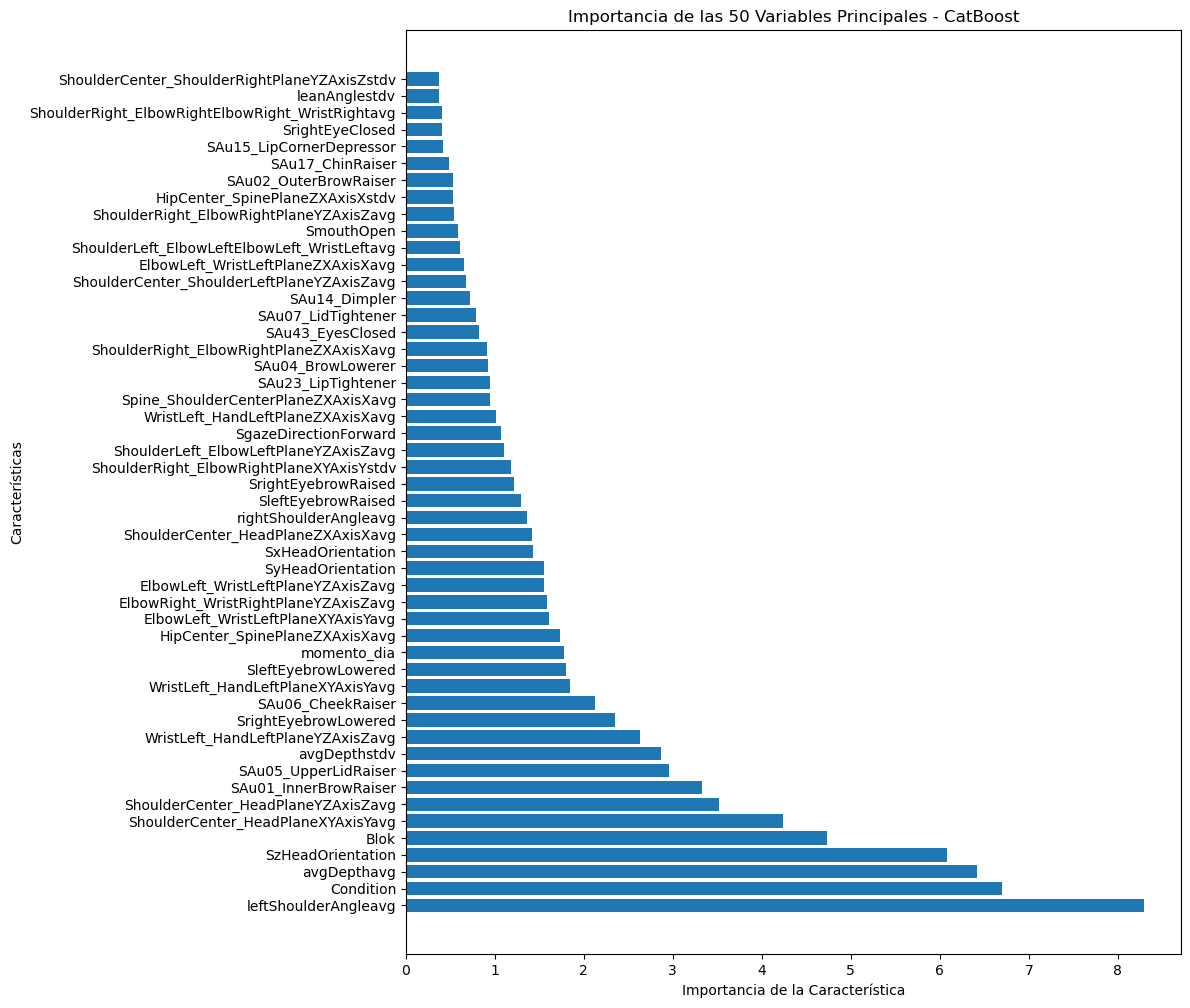

In [27]:
# Importancia de las características
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = best_model_2.get_feature_importance(prettified=True)
feature_importances_df = pd.DataFrame(feature_importances)
top_50_features = feature_importances_df.sort_values(by='Importances', ascending=False).head(50)
plt.figure(figsize=(10, 12))
plt.barh(top_50_features['Feature Id'], top_50_features['Importances'])
plt.xlabel('Importancia de la Característica')
plt.ylabel('Características')
plt.title('Importancia de las 50 Variables Principales - CatBoost')
plt.show()


In [24]:
# Guardar las columnas de X_train en un archivo txt
# with open("columnas_X_train_CatBoost.txt", "w") as f:
#     f.write("\n".join(X_train_columns))